In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# KMeans Clustering Model
from sklearn.cluster import KMeans

# PCA
from sklearn.decomposition import PCA

# Pipeline to combine scalers, PCA and KMeans model
from sklearn.pipeline import make_pipeline

# selecting common working idrectory to allow use of pre_processing.py
import os
os.chdir('/Users/DE7/Desktop/LearningPython/XYZ-Corp')

# bespoke cleaning and data_split functions
from pre_processing import pre_processing

# return current time to track runs for fitting models
from datetime import datetime
def current_time():
    now = datetime.now()
    return now.strftime("%H:%M:%S")

# Bespoke clip values function for the whole dataset
def clip_values(data, features, upper_quantile=0.025, lower_quantile=0.975):
    features = set(data.columns).intersection(features)
    for column in features:
        upp = data[column].quantile(upper_quantile)
        low = data[column].quantile(lower_quantile)
        data[column] = data[column].clip(upper = upp, lower = low)
    return data

In [2]:
# Loading the original dataset
Data = pd.read_csv('data/XYZCorp_LendingData.txt',sep='\t', low_memory = False)

In [3]:
# Using pre_processing function derived for previous models
clean_data, _ = pre_processing(Data)

# Selecting Customer Information columns only
# These will be used to group customers into groups based on their most general cusomter credit related data points
customer_info = ['emp_length',
                 'annual_inc',
                 'home_ownership_MORTGAGE',
                 'home_ownership_NONE',
                 'home_ownership_OTHER',    
                 'home_ownership_OWN',
                 'home_ownership_RENT',
                 'months_since_earliest_cr_line',
                 'verification_status_Source Verified',
                 'verification_status_Verified',
                 'total_acc',
                 'inq_last_6mths',
                 'revol_util',
                 'delinq_2yrs']

clean_data = clean_data[customer_info]

In [4]:
# Separating Categorical features and numberical features.
# Numerical features will be passed through a scaler to ensure same scale of all features
categorical_features = clean_data.select_dtypes(include=['uint8']).columns
numerical_features = clean_data.select_dtypes(include=['float64']).columns

In [5]:
# Clipping 5.0% of outliers on both sides of numerical features only 
clean_data = clip_values(clean_data, features=numerical_features, upper_quantile=0.05, lower_quantile=0.95)

emp_length


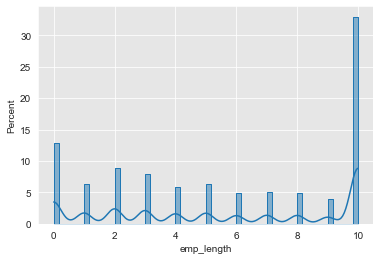

annual_inc


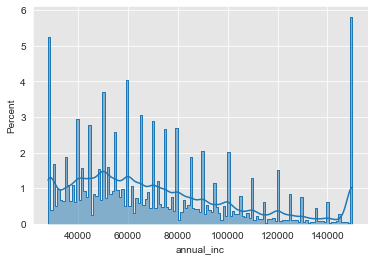

months_since_earliest_cr_line


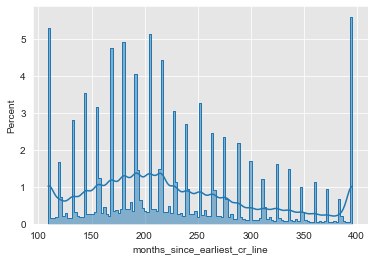

total_acc


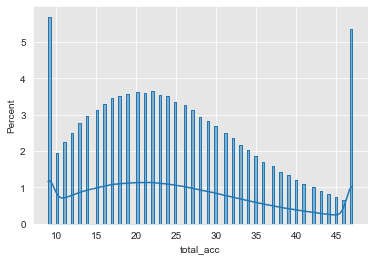

inq_last_6mths


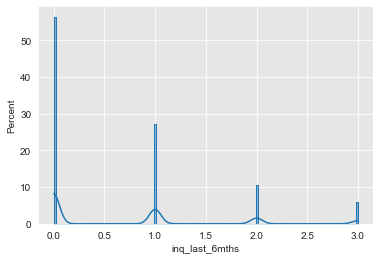

revol_util


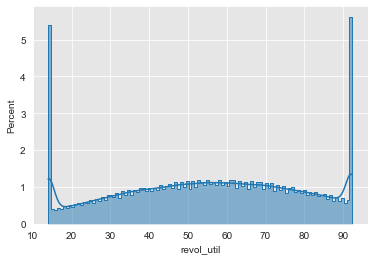

delinq_2yrs


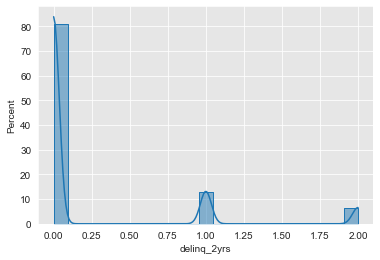

In [6]:
def norm_histplot(dataset, column):
    return sns.histplot(data = dataset, 
                        x=column,
                        element = "step",
                        common_norm=False,
                        cumulative=False,
                        stat = 'percent',
                        kde=True)

# Quick visualization of the distribution of the numerical features. 
figures = []
for column in numerical_features:
    print(column)
    fig = norm_histplot(clean_data, column)
    plt.show()
    figures.append(fig)
    
# overall range of feature values in the data has been well reduced with the clipped values

In [7]:
# Creating a list of scalers to test to be able to iterate through them in the next cell
scalers = [[('scaler', StandardScaler(), numerical_features)],
           [('scaler', MinMaxScaler(), numerical_features)],
           [('scaler', RobustScaler(), numerical_features)]]
scaler_names = ['Standard Scaler','MinMax Scaler','Robust Scaler']

# Range of number of clusters to test for each scaler
no_of_clusters_to_test = range(2, 21)

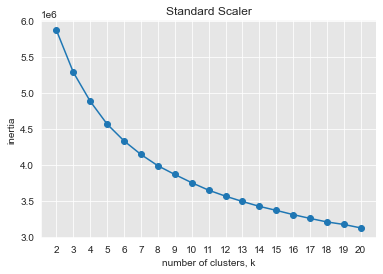

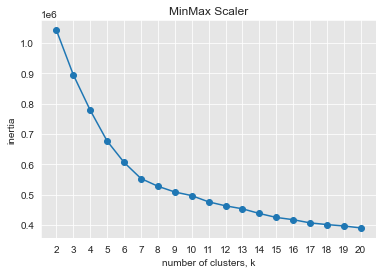

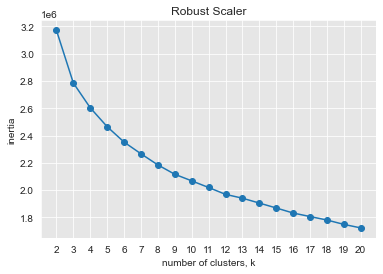

In [8]:
for i in range(len(scalers)):
    # Initialize emply list for cluster intertias
    inertias = []
    # Selecting scaler to test
    scaler = scalers[i]
    # Creating a transformer for the numerical features
    transformer = ColumnTransformer(transformers=scaler,remainder='passthrough')
    # Scaling numerical features with a selected transformer
    scaled_data = transformer.fit_transform(clean_data)
    #iterating through all numbers of clusters to find intertia for all
    for k in no_of_clusters_to_test:
        # KMeans Model
        kmeans = KMeans(n_clusters=k, 
                        max_iter=500, 
                        tol=0.00001,
                        random_state=44)
        kmeans.fit(scaled_data)
        # Append the inertia to the list of inertias
        inertias.append(kmeans.inertia_)
    
    # Plot the clusters intertia for each feature scalling method
    plt.plot(no_of_clusters_to_test, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.title(scaler_names[i])
    plt.xticks(no_of_clusters_to_test)
    plt.savefig("clustering_problem/visualizations/total_cluster_inertia_scaler_{i}.png".format(i = i))
    plt.show()

In [9]:
# Final 2 scalers to be tested and reviewed

# Min Max Scaler - range 0 to 1
min_max_scaler1 = [('scaler', MinMaxScaler(feature_range=(0, 1)), numerical_features)]
transformer1 = ColumnTransformer(transformers=min_max_scaler1,remainder='passthrough')

# Min Max Scaler - range -1 to 1
min_max_scaler2 = [('scaler', MinMaxScaler(feature_range=(-1, 1)), numerical_features)]
transformer2 = ColumnTransformer(transformers=min_max_scaler2,remainder='passthrough')

In [10]:
# Reducing the dimentionality of the data with PCA. Saving the explained variances for the 2 scallers
pca = PCA()
transformers = [transformer1, transformer2]
explained_variance_list = [None for _ in range(2)]
for i in range(len(transformers)):   
    # Create and fit the pipeline
    pipeline = make_pipeline(transformers[i], pca)
    pipeline.fit(clean_data)
    explained_variance_list[i] = list(pca.explained_variance_)

In [11]:
# Verifyinf KMeans clusters inertia drops as the number of clusters increase
# Testing both scalers while keeping 2 or 3 Principal Components
pca1 = PCA(2)
pca2 = PCA(3)

transformers = [transformer1, transformer2,transformer1, transformer2]
pcas = [pca1, pca1, pca2, pca2]
inertias = [[] for _ in range(4)]

for transformer, pca, inertia in zip(transformers, pcas, inertias):
    for k in no_of_clusters_to_test:
        # KMeans Model
        kmeans = KMeans(n_clusters=k, 
                        max_iter=500, 
                        tol=0.00001,
                        random_state=44)
        pipeline = make_pipeline(transformer, pca, kmeans)
        pipeline.fit(clean_data)
        # Append the inertia to the list of inertias
        inertia.append(kmeans.inertia_)

In [12]:
# creating PCA variance dataframe for barchart visualization
pc_variance_df = pd.DataFrame({'0 to 1 Mix Max scaling':explained_variance_list[0],
                               '-1 to 1 Min Max scaling':explained_variance_list[1],
                        'principal component':range(1,15)})
pc_variance_df_melt = pd.melt(pc_variance_df, id_vars="principal component",var_name='scaling', value_name='Explained Variance')

# creating cluster inertia dataframe for line plot visualization
inertia_df = pd.DataFrame({'2 Principal Components, 0 to 1 scaling':inertias[0],
                        '2 Principal Components, -1 to 1 scaling':inertias[1],
                        '3 Principal Components, 0 to 1 scaling':inertias[2],
                        '3 Principal Components, -1 to 1 scaling':inertias[3],
                        'N Clusters':list(no_of_clusters_to_test)})

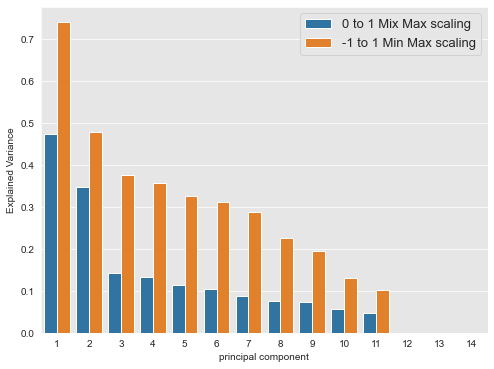

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = 13
sns.barplot(data=pc_variance_df_melt,x='principal component',y='Explained Variance',ax=ax, hue='scaling')
ax.legend(loc = 'upper right')
plt.savefig("clustering_problem/visualizations/Explained_variance.png")
plt.show()

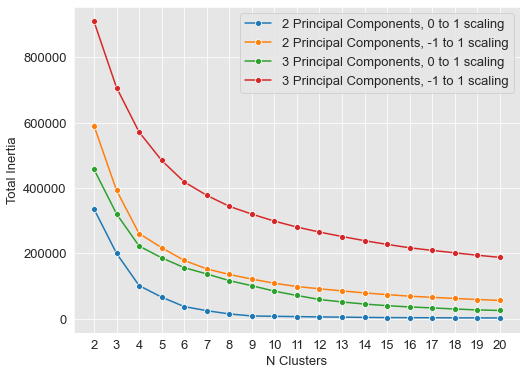

In [14]:
plt.subplots(figsize=(8,6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.rcParams['font.size'] = 13
plot = sns.lineplot(data=inertia_df,x='N Clusters',y='2 Principal Components, 0 to 1 scaling',marker = 'o',palette="Set1")
plot = sns.lineplot(data=inertia_df,x='N Clusters',y='2 Principal Components, -1 to 1 scaling',marker = 'o',palette="Set1")
plot = sns.lineplot(data=inertia_df,x='N Clusters',y='3 Principal Components, 0 to 1 scaling',marker = 'o',palette="Set1")
plot = sns.lineplot(data=inertia_df,x='N Clusters',y='3 Principal Components, -1 to 1 scaling',marker = 'o',palette="Set1")
plot.set(xticks=list(no_of_clusters_to_test), ylabel='Total Inertia')
plt.legend(labels=['2 Principal Components, 0 to 1 scaling',
                   '2 Principal Components, -1 to 1 scaling',
                   '3 Principal Components, 0 to 1 scaling',
                   '3 Principal Components, -1 to 1 scaling'])
plt.savefig("clustering_problem/visualizations/Total_inertial_for_4_transformers.png")
plt.show()

### K-Means Clustering results with Min Max Scaler 0 to 1 range

In [15]:
# Creating and fitting the pipeline for customer clustering
kmeans = KMeans(n_clusters=4, 
                        max_iter=500,
                        tol=0.00001,
                        random_state=44)

pca_final = PCA(3,random_state=44)

pipeline = make_pipeline(transformer1, pca_final, kmeans)

pca_df = pd.DataFrame(pipeline[:-1].fit_transform(clean_data))

pipeline.fit(clean_data)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  Index(['emp_length', 'annual_inc', 'months_since_earliest_cr_line',
       'total_acc', 'inq_last_6mths', 'revol_util', 'delinq_2yrs'],
      dtype='object'))])),
                ('pca', PCA(n_components=3, random_state=44)),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=4, random_state=44,
                        tol=1e-05))])

In [16]:
# predicted clusters
clusters = pipeline.predict(clean_data)
pca_df['cluster'] = clusters

# Sampling the data for visualizations
pca_df_sample = pca_df.sample(frac=0.003,random_state=44)
clusters = pca_df_sample['cluster']

In [17]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'PC 1 -->'),yaxis = dict(title  = 'PC 2 -->'),zaxis = dict(title  = 'PC 3 -->'))

scatter_3d = go.Scatter3d(x=pca_df_sample[0], y=pca_df_sample[1], z=pca_df_sample[2], mode='markers',marker=dict(color = clusters, size= 10, line=dict(color= 'black',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [scatter_3d]
fig = go.Figure(data = data, layout = layout)
fig.show()

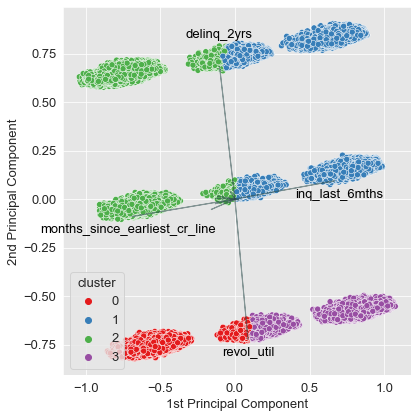

In [18]:
# cleaning lables of insigificant features so they don't clutter the plot
labels = list(clean_data.columns)
labels[0]=''
labels[1]=''
labels[2]=''
labels[3]=''
labels[4]=''
labels[5]=''
labels[6]=''
labels[8]=''
labels[9]=''
labels[10]=''


components = np.transpose(pca_final.components_[0:2, :])
n = components.shape[0]
plt.subplots(figsize=(6,6))
for i in range(n):
        # Creating biplots to visualize loadings of each feature on the principal components
        plt.arrow(0, 0, components[i,0],components[i,1],color = 'darkslategray',alpha = 0.5)
        if i == 7 or i == 11:
            plt.text(components[i,0]* 1.05,
                     components[i,1]-0.07,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        elif i == 13:
            plt.text(components[i,0]* 1.05,
                     components[i,1]+0.17,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        else:   
            plt.text(components[i,0]* 1.05,
                     components[i,1] * 1.10,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center')
            
# Scatter plot of the customer records after PCA, coloured by the mapped clusters
plot = sns.scatterplot(data=pca_df.sample(frac=0.10,random_state=44),
                x=0,
                y=1,
                hue="cluster",
                palette="Set1",
                legend=True)
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.tight_layout()
plt.savefig("clustering_problem/visualizations/customers_clustering_with_PCA_1a.png")
plt.show()

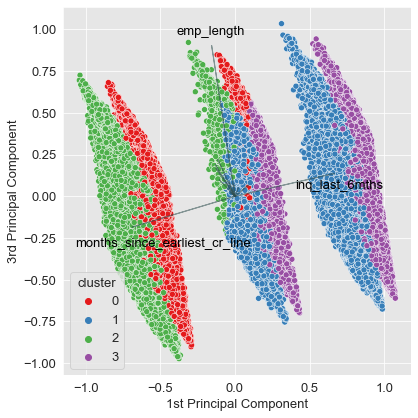

In [19]:
# cleaning lables of insigificant features so they don't clutter the plot
labels = list(clean_data.columns)
labels[1]=''
labels[2]=''
labels[3]=''
labels[4]=''
labels[5]=''
labels[6]=''
labels[8]=''
labels[9]=''
labels[10]=''
labels[12]=''
labels[13]=''


components = np.transpose(pca_final.components_[[0,2], :])
n = components.shape[0]
plt.subplots(figsize=(6,6))
for i in range(n):
        # Creating biplots to visualize loadings of each feature on the principal components
        plt.arrow(0, 0, components[i,0],components[i,1],color = 'darkslategray',alpha = 0.5)
        if i == 11:
            plt.text(components[i,0]* 1.05,
                     components[i,1]-0.07,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        elif i == 7:
            plt.text(components[i,0]+0.2,
                     components[i,1]-0.1,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        else:   
            plt.text(components[i,0]* 1.05,
                     components[i,1] * 1.10,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center')
            
# Scatter plot of the customer records after PCA, coloured by the mapped clusters
plot = sns.scatterplot(data=pca_df.sample(frac=0.10,random_state=44),
                x=0,
                y=2,
                hue="cluster",
                palette="Set1",
                legend=True)
plt.xlabel("1st Principal Component")
plt.ylabel("3rd Principal Component")
plt.tight_layout()
plt.savefig("clustering_problem/visualizations/customers_clustering_with_PCA_1b.png")
plt.show()

### K-Means Clustering results with Min Max Scaler -1 to 1 range

In [20]:
kmeans = KMeans(n_clusters=4, 
                        max_iter=500,
                        tol=0.00001,
                        random_state=44)

pca_final = PCA(3,random_state=44)

pipeline = make_pipeline(transformer2, pca_final, kmeans)

pca_df = pd.DataFrame(pipeline[:-1].fit_transform(clean_data))

pipeline.fit(clean_data)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  Index(['emp_length', 'annual_inc', 'months_since_earliest_cr_line',
       'total_acc', 'inq_last_6mths', 'revol_util', 'delinq_2yrs'],
      dtype='object'))])),
                ('pca', PCA(n_components=3, random_state=44)),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=4, random_state=44,
                        tol=1e-05))])

In [21]:
# predicted clusters
clusters = pipeline.predict(clean_data)
pca_df['cluster'] = clusters

# Sampling the data for visualizations
pca_df_sample = pca_df.sample(frac=0.0015,random_state=44)
clusters = pca_df_sample['cluster']

In [22]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'PC 1 -->'),yaxis = dict(title  = 'PC 2 -->'),zaxis = dict(title  = 'PC 3 -->'))

scatter_3d = go.Scatter3d(x=pca_df_sample[0], y=pca_df_sample[1], z=pca_df_sample[2], mode='markers',marker=dict(color = clusters, size= 10, line=dict(color= 'black',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [scatter_3d]
fig = go.Figure(data = data, layout = layout)
fig.show()

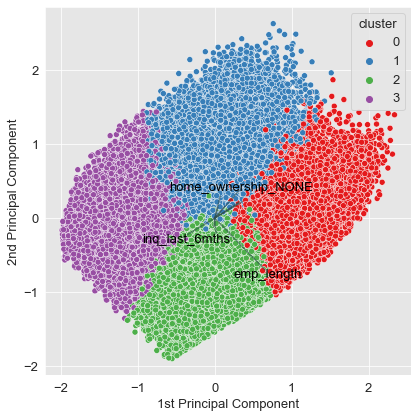

In [23]:
labels = list(clean_data.columns)
# Removing insignificant labels
labels[1]=''
labels[2]=''
labels[4]=''
labels[5]=''
labels[6]=''
labels[7]=''
labels[8]=''
labels[9]=''
labels[10]=''
labels[12]=''
labels[13]=''


components = np.transpose(pca_final.components_[0:2, :])
n = components.shape[0]
plt.subplots(figsize=(6,6))
for i in range(n):
        # Creating biplots to visualize loadings of each feature on the principal components
        plt.arrow(0, 0, components[i,0],components[i,1],color = 'darkslategray',alpha = 0.5)
        if i == 7 or i == 11:
            plt.text(components[i,0]* 1.05,
                     components[i,1]-0.07,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        elif i == 13:
            plt.text(components[i,0]* 1.05,
                     components[i,1]+0.17,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        else:   
            plt.text(components[i,0]* 1.05,
                     components[i,1] * 1.10,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center')

# Scatter plot of the customer records after PCA, coloured by the mapped clusters
plot = sns.scatterplot(data=pca_df.sample(frac=0.10,random_state=44),
                x=0,
                y=1,
                hue="cluster",
                palette="Set1",
                legend=True)
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.tight_layout()
plt.savefig("clustering_problem/visualizations/customers_clustering_with_PCA_2a.png")
plt.show()

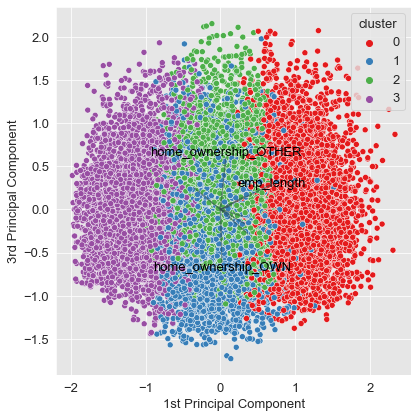

In [24]:
labels = list(clean_data.columns)
# Removing insignificant labels
labels[1]=''
labels[2]=''
labels[3]=''
labels[6]=''
labels[7]=''
labels[8]=''
labels[9]=''
labels[10]=''
labels[11]=''
labels[12]=''
labels[13]=''


components = np.transpose(pca_final.components_[[0,2], :])
n = components.shape[0]
plt.subplots(figsize=(6,6))
for i in range(n):
        # Creating biplots to visualize loadings of each feature on the principal components
        plt.arrow(0, 0, components[i,0],components[i,1],color = 'darkslategray',alpha = 0.5)
        if i == 11:
            plt.text(components[i,0]* 1.05,
                     components[i,1]-0.07,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        elif i == 7:
            plt.text(components[i,0]+0.2,
                     components[i,1]-0.1,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center') 
        else:   
            plt.text(components[i,0]* 1.05,
                     components[i,1] * 1.10,
                     labels[i],
                     color = 'k',
                     ha = 'center',
                     va = 'center')

# Scatter plot of the customer records after PCA, coloured by the mapped clusters
plot = sns.scatterplot(data=pca_df.sample(frac=0.02,random_state=44),
                x=0,
                y=2,
                hue="cluster",
                palette="Set1",
                legend=True)
plt.xlabel("1st Principal Component")
plt.ylabel("3rd Principal Component")
plt.tight_layout()
plt.savefig("clustering_problem/visualizations/customers_clustering_with_PCA_2b.png")
plt.show()